# Trabajo Práctico 1 
### Clasificación sobre datos simulados. 

## Introducción
Para este trabajo, hemos creado una función generadora de minions. Sobre cada minion, hemos medido 200 características que representan habilidades que poseen en distintas tareas (relacionadas al Mal).  

El doctor Nefario ha ideado una fórmula para determinar si un minion es o no apto para concretar su plan para conquistar el mundo. De esta manera ha etiquetado más de 500 minions. Lamentablemente, ha perdido dicha fórmula y necesita seguir decidiendo si nuevos minions son o no aptos para su macabro plan.

Es por esto que nuestro objetivo será construir clasificadores que estimen lo mejor posible la probabilidad de que nuevos minions sean o no aptos para concretar el plan de conquista y así facilitarle las cosas al doctor Nefario.

Por otra parte, ya que el doctor Nefario tuvo problemas con equipos que sobreestiman sus resultados, decidió guardarse varias etiquetas extra que no compartirá con nadie, y que luego utilizará para elegir al mejor equipo, al cual contratará para (de una vez por todas) conquistar el mundo. 


En concreto:

Tendrán disponible una matriz de datos $X$ de $500$ filas en donde cada fila $x^{(i)}$ representa un vector de $200$ características de cada instancia. Es decir, $\textbf{x}^{(i)} = x_1^{(i)}, \dots, x_{200}^{(i)}$ con $i$ entre $1$ y $500$. Además, tendrán y, un vector de $500$ posiciones con dos posibles valores: $True$ y $False$. 

Por otra parte, tendrán disponibles más instancias de evaluación $X_{competencia}$ sin las respectivas etiquetas que utilizaremos para evaluar sus resultados. 



In [85]:
# PREAMBULOS
%matplotlib inline

SEED = 1234

# Commons imports
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from IPython.display import Image, display, HTML
from sklearn.externals.six import StringIO
import pydotplus
from time import time
import itertools
import graphviz

from scipy.stats import randint as sp_randint

import numpy as np
np.set_printoptions(precision=4)
np.random.seed(SEED)

import pandas as  pd
pd.set_option('display.max_rows', 10)
pd.set_option('display.max_columns', 15)
pd.set_option('precision', 4)

import matplotlib.pyplot as plt
import seaborn as sns


import sklearn.model_selection

## Classifiers
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV

import sklearn.ensemble
import sklearn.svm

In [2]:
# Common functions
def dibujar_arbol(clf):
    dot_data = StringIO()
    sklearn.tree.export_graphviz(clf, out_file=dot_data,  
                    filled=True,
                    special_characters=True)
    graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
    display(Image(graph.create_png()))

In [18]:
# Carga de datos
X = pd.read_csv("X.csv", index_col="index")
Y = pd.read_csv("y.csv", index_col="index", dtype=int)  # Cargamos los valores booleanos (True y False)
                                                        # como números (1 y 0) para facilitar el manejo luego. 
    
X_competencia = pd.read_csv("X_competencia.csv", index_col="index")
Y_competencia_ejemplo = pd.read_csv("y_competencia_ejemplo.csv", index_col="index")

display(X.head(5))
display(Y.head(5))

# Descomentar si quieren ver los datos para la competencia:
# display(X_competencia) 
# display(y_competencia_ejemplo)

,0,1,2,3,4,5,6,...,193,194,195,196,197,198,199
index,,,,,,,,,,,,,,,
0,1.4914,0.1644,1.2315,1.2429,1.5576,0.0455,0.1302,...,-1.1983,-0.0118,1.5375,-0.7727,-0.1401,2.0871,-0.8312
1,-0.2749,0.2780,-1.3108,0.6801,-0.5503,0.6359,-0.4478,...,1.2190,-0.3190,-0.6446,-0.0061,-1.2374,-1.3291,-1.3265
2,-0.2243,-0.5710,-0.2712,-0.1328,-1.0045,0.9315,-1.4507,...,0.9459,0.1430,-0.1989,-0.0393,-0.5866,2.2507,1.4925
3,0.5853,-0.8532,-0.2723,-0.5493,-2.9824,-0.1697,-0.0430,...,1.6488,-0.7363,-0.8866,-1.2717,-0.1493,0.2007,-1.4820
4,-1.4155,1.4187,0.6027,-0.7993,0.2939,-0.1796,-0.7140,...,1.1314,-0.4230,-0.2685,0.3045,-1.2245,-1.9421,1.5186


,output
index,
0,0
1,0
2,0
3,0
4,1


TODO: algún análisis del input no estaria mal

posibilidades:
1) no se puede descartar que sean normales
2) correspondencia con normales con media 0 y varianza 1
3) correlación entre variables?
4) porcentaje de cada clase en la muestra


## Ejercicio 1

### Separación de datos

Contarán con una cantidad limitada de datos, por lo cual es importante tomar una buena decisión en el momento de empezar a utilizarlos. En este punto pedimos que evalúen cómo separar sus datos para desarrollo y para evaluación tomando en cuenta la competencia. 

Tamaño conj de entrenamiento: (450, 200), tamaño conj de clases de entrenamiento: (450, 1). porcentaje de clase 1 en conj 0.46.
Tamaño conj de test: (50, 200), tamaño conj de clases de test: (50, 1), porcentaje de clase 1 en conj 0.46.


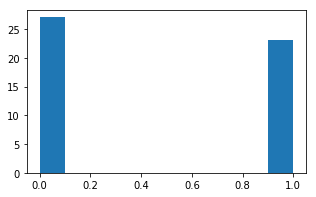

In [65]:
percentage_train = 9/10
X_train, X_held_out, Y_train, Y_held_out = sklearn.model_selection.train_test_split(
    X, Y, train_size=percentage_train, stratify=Y
)

# Just to check sizes and percentage of class 1 in each one
print("Tamaño conj de entrenamiento: {}, tamaño conj de clases de entrenamiento: {}. porcentaje de clase 1 en conj {:.2f}.".format(
        X_train.shape, Y_train.shape, int(Y_train.sum())/len(Y_train))
)
print("Tamaño conj de test: {}, tamaño conj de clases de test: {}, porcentaje de clase 1 en conj {:.2f}.".format(
        X_held_out.shape, Y_held_out.shape, int(Y_held_out.sum())/len(Y_held_out))
)

plt.figure(figsize=(5, 3))
plt.hist(np.array(Y_held_out))  # muestra un histograma para la distribución de y.
plt.show()

## Ejercicio 2

### Construcción de modelos

Para este punto, la tarea consiste en construir y evaluar modelos de tipo árbol de decisión, de manera de obtener una estimación realista de la performance de los mismos. 

1. Entrenar un árbol de decisión con altura máxima 3 y el resto de los hiperparámetros en default. 
2. Estimar la performance del modelo utilizando K-fold cross validation con K = 5, con las métricas “Accuracy” y “ROC AUC”. Para ello, se pide medir la performance en cada partición tanto sobre el fold de validación como sobre los folds de entrenamiento. Luego, completar la primera tabla.
3. Entrenar árboles de decisión para cada una de las siguientes combinaciones y completar la segunda tabla.

----

**EJERCICIO EXTRA: Usar la implementación de árboles de decisión que realizaron para la guía de ejercicios de la materia. Adaptarla para que cumpla con la interfaz requerida por sklearn, asegurarse de que funcione con variables continuas y reproducir las tablas anteriores.   **

----

,Accuracy (entrenamiento),Accuracy (validación),AUC ROC (entrenamiento),AUC ROC (validación)
Fold de validación,,,,
1,0.8106,0.6593,0.8748,0.7177
2,0.8167,0.6444,0.8801,0.6294
3,0.8194,0.7333,0.8801,0.7618
4,0.8250,0.6889,0.8865,0.6882
5,0.8366,0.6517,0.8828,0.6745


['__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getstate__', '__gt__', '__hash__', '__init__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__setstate__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_add_text', '_adjustable', '_agg_filter', '_alpha', '_anchor', '_animated', '_aspect', '_autoscaleXon', '_autoscaleYon', '_axes', '_axes_class', '_axes_locator', '_axisbelow', '_cachedRenderer', '_clipon', '_clippath', '_connected', '_contains', '_current_image', '_facecolor', '_frameon', '_gci', '_gen_axes_patch', '_gen_axes_spines', '_get_axis_list', '_get_lines', '_get_patches_for_fill', '_get_view', '_gid', '_gridOn', '_hold', '_init_axis', '_label', '_left_title', '_make_twin_axes', '_mouseover', '_navigate', '_navigate_mode', '_oid', '_on_units_changed', '_originalPosition', '_path_effects', '_pcolorargs', '_picker', '_position',

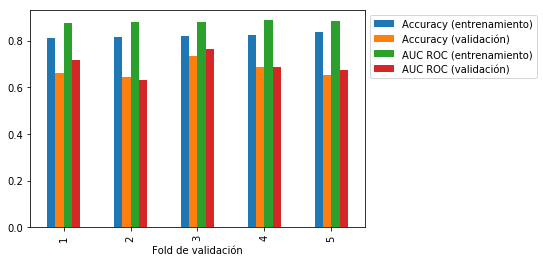

In [322]:
def plot_accuracy_and_auc_roc_on_train_and_test(metrics_results,
        tabble_header='Resultado Ejercicio 2.2: accuracy y roc auc en árboles de decisión con altura máxima de 3'):
    """
    Param metrics_results :type: dict should at least contains keys 
    ['train_accuracy', 'test_accuracy', 'train_roc_auc', 'test_roc_auc'].
    """
    
    df = pd.DataFrame(index=range(1,6))
    df.index.name = "Fold de validación"

    df["Accuracy (entrenamiento)"] = metrics_results['train_accuracy']
    df["Accuracy (validación)"] = metrics_results['test_accuracy']
    df["AUC ROC (entrenamiento)"] = metrics_results['train_roc_auc']
    df["AUC ROC (validación)"] = metrics_results['test_roc_auc']
    display(HTML('<h3> {} </h3>'.format(tabble_header)))
    display(df)

    fig = df.plot(kind="bar")
    plt.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0))
    plt.show()
    
    return

X_train_np = np.array(X_train)
Y_train_np = np.array(Y_train).ravel()


# In order to avoid using the same variable's names in different excercises,
# each excercise is a function with local variables

def excercise_2_2():
    decision_tree = DecisionTreeClassifier(max_depth=3)

    metric_scores = sklearn.model_selection.cross_validate(
        decision_tree, X_train_np, Y_train_np, scoring=('roc_auc', 'accuracy'), cv=5, n_jobs=4
    )

    plot_accuracy_and_auc_roc_on_train_and_test(metric_scores)
    return

excercise_2_2()

,Altura Máxima,Medida de Separación,Promedio AUC ROC (entrenamiento),Promedio AUC ROC (validación)
0,3,Gini,0.8808,0.6911
1,5,Gini,0.9720,0.6537
2,Inifinity,Gini,1.0000,0.6505
3,3,Ganancia de Información,0.8778,0.7209
4,5,Ganancia de Información,0.9728,0.7042
5,Inifinity,Ganancia de Información,1.0000,0.6749


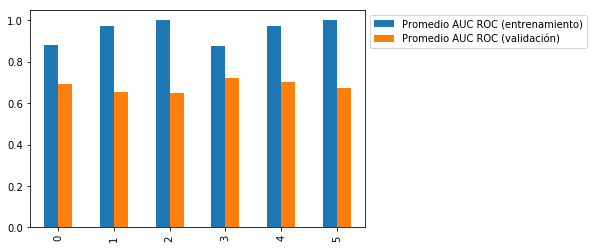

In [70]:
def plot_table_excercise_2_3(metrics_scores,
                             table_header='Resultado Ejercicio 2.3: árboles de decisión con diferentes hiperparámetros'):
    """
    Param metrics_scores :type: dict should at least has 'train_results' and 'test_results' keys
    """
    df = pd.DataFrame(index=range(0,6))

    df['Altura Máxima'] = [3, 5, 'Inifinity'] * 2
    df['Medida de Separación'] = ['Gini'] * 3 + ['Ganancia de Información'] * 3
    df['Promedio AUC ROC (entrenamiento)'] = metrics_scores['train_results']
    df['Promedio AUC ROC (validación)'] = metrics_scores['test_results']
   
    display(HTML("<h3> {} </h3>".format(table_header)))
    display(df)
    
    df.plot(kind="bar")
    plt.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0))
    plt.show()
    
    return

def excercise_2_3():
    metric_scores = { 'train_results' : [], 'test_results' : [] }
            
    for _criterio, _depth in itertools.product(['gini', 'entropy'], [3, 5, None]):
        
        decision_tree = DecisionTreeClassifier(max_depth=_depth, criterion=_criterio)
        
        tree_metric_score = sklearn.model_selection.cross_validate(
            decision_tree, X_train_np, Y_train_np, scoring='roc_auc', cv=5
        )
            
        metric_scores['train_results'].append(np.mean(tree_metric_score['train_score']))
        metric_scores['test_results'].append(np.mean(tree_metric_score['test_score']))
    
    plot_table_excercise_2_3(metric_scores)
        
excercise_2_3()

## Ejercicio 3: Comparación de algoritmos


Se pide explorar distintas combinaciones de algoritmos de aprendizaje e hiperparámetros, de manera de buscar una performance óptima. Para este ejercicio es necesario que evalúen posibilidades utilizando la técnica de Grid Search. Como métrica de performance, usar siempre el área bajo la curva (AUC ROC) resultante de 5-fold cross-validation. 

Algoritmos a probar: KNN, árboles de decisión, LDA, Naive Bayes y SVM. Hiperparámetros: Revisar la documentación de cada uno para la búsqueda de combinaciones prometedoras.  

Se pide generar un reporte que contenga: 

1. Una descripción de las distintas combinaciones consideradas y su performance asociada (las que consideren relevantes, con al menos la mejor combinación para cada algoritmo). 

1. Una breve explicación de los factores que creen que produjeron dicho resultado. 

En este punto evaluaremos tanto los hiperparámetros elegidos como las conclusiones relacionadas a por qué piensan que ciertos algoritmos funcionan mejor que otros para estos datos. 



----

**EJERCICIO EXTRA**: Utilizar RandomizedSearchCV con rangos de parámetros que contengan a los utilizados en el GridSearch. Analizar si se encontraron mejores combinaciones de parámetros que no hayan sido tenidas en cuenta con el GridSearch y cuál fue la diferencia de tiempo de ejecución. 

----

In [47]:
def top_results(grid, top=5):
    print("Top {} combinaciones".format(top))
    df = pd.DataFrame(grid.cv_results_["params"])
    df["mean_score_validation"] = grid.cv_results_["mean_test_score"]
    df["mean_score_training"] = grid.cv_results_["mean_train_score"]
    display(df.sort_values(by="mean_score_validation", ascending=False).head(top))
    return

def apply_grid_search_on_classifier_and_parameters(classifier, classifier_parameters, _X_train, _Y_train,
                                                   metrics_names=('roc_auc'), cv=5, n_jobs=4):
    _clf = GridSearchCV(
        classifier, classifier_parameters, scoring=metrics_names, cv=cv, n_jobs=n_jobs
    )
    
    return _clf.fit(_X_train, _Y_train)    

### Grid Search sobre clasificadores

In [48]:
# A function to apply grid on each Classifier with its own possible arguments  

def knn_grid_search_parametrization(_X_train, _Y_train):
    knn_arguments = [
        {
            'algorithm': ['brute'],
            'n_neighbors': range(1, 350, 50),
            'weights': ['distance','uniform']
        },
        {
            'algorithm': ['ball_tree', 'kd_tree'],
            'n_neighbors': range(1, 350, 50),
            'weights': ['distance','uniform'],
            'p': [1, 2, 200],
            'leaf_size': range(30, 150, 30)
        }
    ]
    
    knn_classifier = KNeighborsClassifier()
    
    return apply_grid_search_on_classifier_and_parameters(knn_classifier, knn_arguments, _X_train, _Y_train)

def linear_discriminant_analysis_grid_search_parametrization(_X_train, _Y_train):
    # 'n_components' seems to not impact in performance, so this is ignored
    #LDA_arguments_para_despues = [
    #    {'solver': ['svd'], 'n_components': [0, 1, 199]},
    #    {
    #        'solver': ['lsqr', 'eigen'],
    #        'shrinkage': list(np.linspace(0,1,10)) + [None,'auto'],
    #        'n_components': [0, 1, 199]
    #    }
    #]
    lda_arguments = [
        {'solver': ['svd']},
        {
            'solver': ['lsqr', 'eigen'],
            'shrinkage': list(np.linspace(0,1,11)) + [None,'auto']
        }
    ]
    
    lda_classifier = LinearDiscriminantAnalysis()
    
    return apply_grid_search_on_classifier_and_parameters(lda_classifier, lda_arguments, _X_train, _Y_train)

# Linear SVM
def support_vector_machine_grid_serch_parametrization(_X_train, _Y_train):
    SVM_Linear_arguments = [
        {
            'C': np.linspace(0.01,20,100),
            'loss': ['squared_hinge'],
            'penalty': ['l1', 'l2'],
            'dual': [False],
            'fit_intercept': [False, True]
        }
    ]

    linearsvm_classifier = sklearn.svm.LinearSVC()

    return apply_grid_search_on_classifier_and_parameters(
        linearsvm_classifier, SVM_Linear_arguments, _X_train, _Y_train
    )

### Resultados

### Árboles de decisión

In [110]:
def tree_grid_search_parametrization(_X_train, _Y_train):
    tree_arguments = [
        {
            'criterion': ['gini', 'entropy'],
            'splitter': ['best', 'random'],
            'max_depth': list(range(3, 15, 2)) + list(range(15, 150, 10)) + [None],
            'max_features': list(range(25, 200, 10)) + [7, 14, 20, None],
            'max_leaf_nodes': list(range(10, 501, 50)) + [None]
        }
    ]
    
    tree_classifier = DecisionTreeClassifier(random_state = SEED) # it doesn't seem to be taking numpy.seed
    
    return apply_grid_search_on_classifier_and_parameters(tree_classifier, tree_arguments, _X_train, _Y_train)

#grid_tree = tree_grid_search_parametrization(X_train_np, Y_train_np)
top_results(grid_tree,10)

Top 10 combinaciones


,criterion,max_depth,max_features,max_leaf_nodes,splitter,mean_score_validation,mean_score_training
438,gini,3.0,14.0,NaN,best,0.7766,0.8413
10602,entropy,3.0,14.0,NaN,best,0.7714,0.8362
10714,entropy,5.0,55.0,10.0,best,0.7708,0.8954
11198,entropy,7.0,55.0,10.0,best,0.7708,0.8954
12166,entropy,11.0,55.0,10.0,best,0.7708,0.8954
18942,entropy,135.0,55.0,10.0,best,0.7708,0.8954
17490,entropy,105.0,55.0,10.0,best,0.7708,0.8954
19910,entropy,NaN,55.0,10.0,best,0.7708,0.8954
18458,entropy,125.0,55.0,10.0,best,0.7708,0.8954
11682,entropy,9.0,55.0,10.0,best,0.7708,0.8954


### Parámetros
Se varía la forma de medir la calidad de una separación (criterion) en un nodo como también la forma en la que se elige entre las posibles (splitter). Se varía también la cantidad máxima de predictores a considerar para buscar la mejor separación. 
Nos pareció de interés variar la altura y la cantidad de hojas permitidas en el árbol para ver como generaliza una árbol pequeño o con pocas hojas respecto a uno sin limitación.

### Resultados
Se obtuvieron mejores resultados en los datos de validación respecto a los obtenidos en el ejercicio 2.2 y 2.3 con resultados en los datos de entrenamiento menores (el top 10 está por debajo de %90).

Si nuestros datos hubieran sido linealmente separables, hubieramos obtenido mejores resultados.
    
    
Los predictores son permutados en cada nodo al momento de buscar una separación, por lo que considerar diferentes de no fijar una semilla, mismos parámetros y datos pueden concluir en árboles distintos. Se fijo el parámetro $\textit{random_state}$ con el mismo valor que la seed de numpy para obtener de manera determinista un árbol.

Algunas preguntas que podemos hacernos son

1. ¿Qué features separa y cómo el mejor árbol obtenido?
2. ¿Cómo afecta el cambiar de algunos hiperaparámetros?
    + ¿Cómo cambia el auc roc mientras aumentamos la profundidad máxima del árbol?
    + ¿Cómo cambia el auc roc mientras aumentamos la cantidad de hojas máxima del árbol?

1)¿Qué features separa y cómo el mejor árbol obtenido?

In [317]:
def create_decision_tree_classifier_with_params(parameter_combination):
    criterion = parameter_combination['criterion']
    max_depth = parameter_combination['max_depth']
    max_features = parameter_combination['max_features']
    max_leaf_nodes = parameter_combination['max_leaf_nodes']
    splitter = parameter_combination['splitter']
    
    return DecisionTreeClassifier(
            criterion=parameter_combination['criterion'],
            max_depth= None if max_depth is None or np.isnan(max_depth) else int(max_depth),
            max_features= None if max_features is None or np.isnan(max_features) else int(max_features),
            max_leaf_nodes= None if max_leaf_nodes is None or np.isnan(max_leaf_nodes) else int(max_leaf_nodes),
            splitter=parameter_combination['splitter'],
            random_state=SEED
    )

# Some functions to show difference between trees
def calculate_nodes_depth_and_leaves(tree_classifier):
    """
    Param tree_classifier :type: DecisionTreeClassifier.
    
    Traverse the internal tree_ structure tree_classifier in order to compute, its depth, amount of nodes
    and amount of leaves.
    
    Trivial tree (only one node) has depth equals to 0.
    """
    n_nodes = tree_classifier.tree_.node_count
    children_left = tree_classifier.tree_.children_left
    children_right = tree_classifier.tree_.children_right

    # The tree structure can be traversed to compute various properties such
    # as the depth of each node and whether or not it is a leaf.
    max_depth_used = -1
    leaves_amount = 0
    stack = [(0, max_depth_used)]  # (root_node_id, its_parent_depth)
    while len(stack) > 0:
        node_id, parent_depth = stack.pop()
        
        max_depth_used = max(max_depth_used, parent_depth+1) # keep max depth
        
        # If it's a leaf its childs are equal
        if (children_left[node_id] != children_right[node_id]):
            stack.append((children_left[node_id], parent_depth + 1))
            stack.append((children_right[node_id], parent_depth + 1))
        else:
            leaves_amount += 1
    
    return n_nodes, max_depth_used, leaves_amount # nodes_count, max_depth_used, leaves_count 

Cantidad de nodos 19
Altura del árbol 6
Cantidad de hojas 10


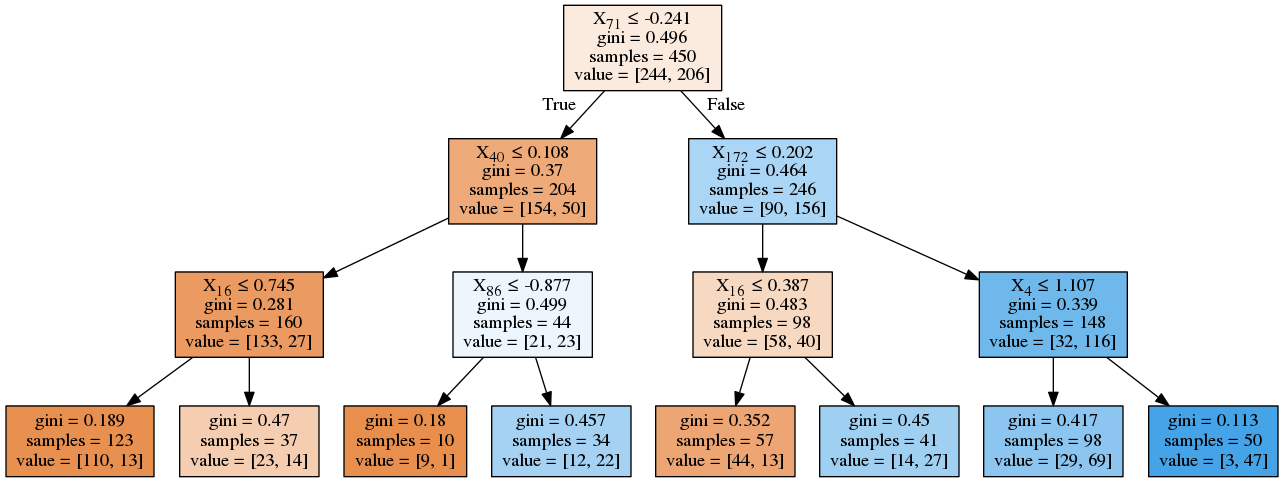

In [318]:
best_tree = create_decision_tree_classifier_with_params(grid_tree.best_params_)
print('Cantidad de nodos {}\nAltura del árbol {}\nCantidad de hojas {}'.format(
        *calculate_nodes_depth_and_leaves(arbol_ganador))
)
dibujar_arbol(best_tree.fit(X_train_np, Y_train_np))

2) ¿Cómo afecta el cambiar de algunos hiperaparámetros?
    - ¿Cómo cambia el auc roc mientras aumentamos la profundidad máxima del árbol?
    - ¿Cómo cambia el auc roc mientras aumentamos la cantidad de hojas máxima del árbol?
    

Para ver la primera pregunta consideraramos los árboles sin límite en la cantidad de hojas y en la segunda los árboles sin límite en la cantidad profundidad. Creamos un árbol para cada combinación de hiperparámetros utilizando la misma semilla pero en este caso fiteamos sobre todo el set de datos de entrenamiento y no sobre un fold sabiendo que el árbol no será exactamente el mismo pero 'similar' (el valor que nos muestra GridSearch es un promedio de los obtenidos por los folds).

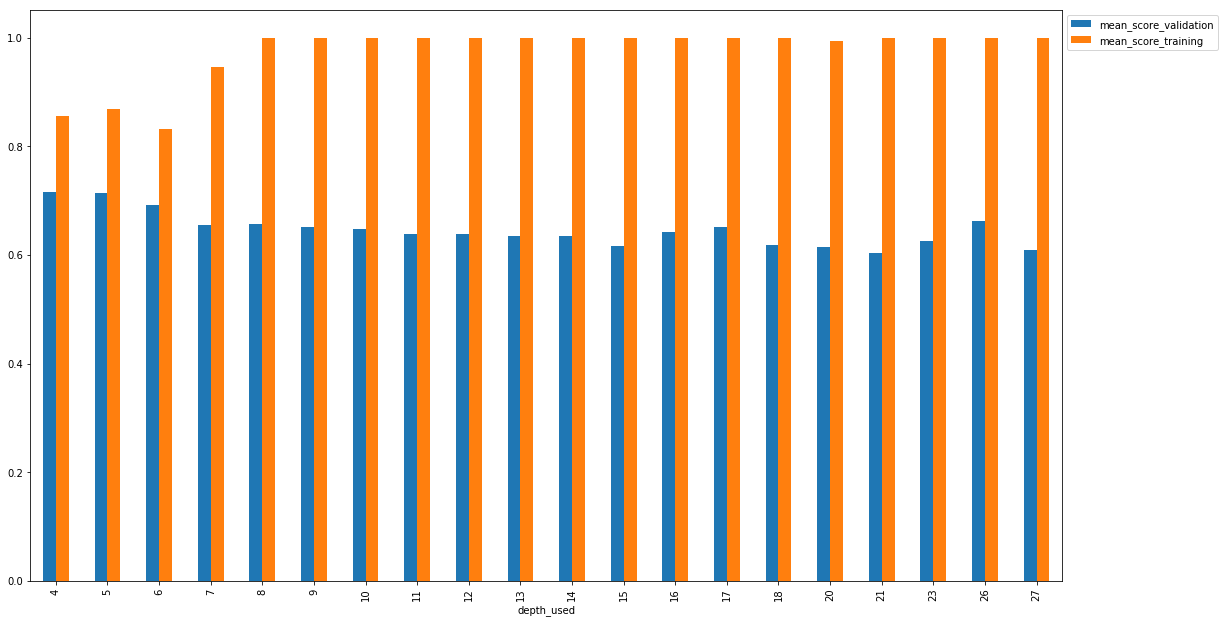

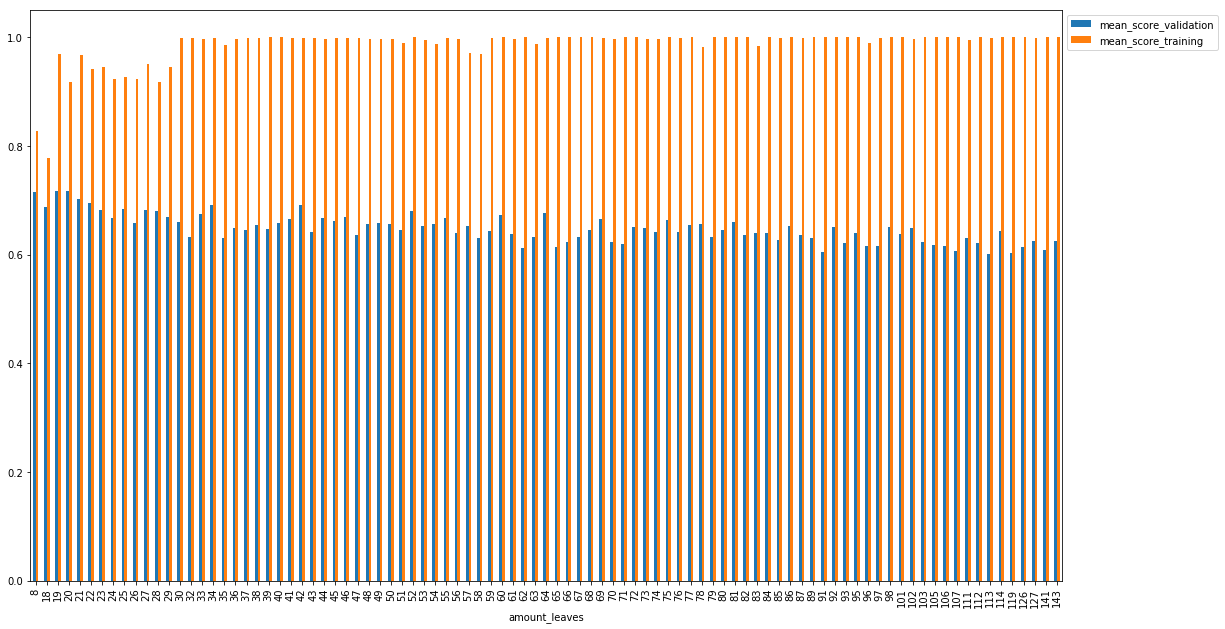

In [325]:
def add_nodes_depth_and_leaves_features_of_tree_for_each_parameter_combination(
    parameter_combination_df, _X_train, _Y_train):
    """
    Param parameter_combination_df :type: DataFrame contains a serie of hiperparameters to create
    DecisionTreeClassifiers.
    
    For each one compute the depth and amount of leaves and nodes of the internval tree structure.
    This is information is returned in the input DataFrame as new columns.
    """
    
    amount_nodes = np.zeros(shape=len(parameter_combination_df.index), dtype=np.int64)
    depth_used = np.zeros(shape=len(parameter_combination_df.index), dtype=np.int64)
    amount_leaves = np.zeros(shape=len(parameter_combination_df.index), dtype=np.int64)
    
    _index=0
    for _, parameter_combination in parameter_combination_df.iterrows():
        _tree_classifier = create_decision_tree_classifier_with_params(parameter_combination)
        _tree_classifier.fit(X_train, Y_train)
        amount_nodes[_index], depth_used[_index], amount_leaves[_index] = calculate_nodes_depth_and_leaves(_tree_classifier)
        _index +=1
    
    parameter_combination_df['amount_nodes'] = amount_nodes
    parameter_combination_df['depth_used'] = depth_used
    parameter_combination_df['amount_leaves'] = amount_leaves
    
    return parameter_combination_df

def plot_dataframe_as_bar(dataframe):
    fig = dataframe.plot(kind="bar", figsize=(18.5, 10.5))
    plt.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0))
    plt.show()
    return

def plot_score_while_increasing_depth(df_without_depth_bound, _X_train, _Y_train):
    df_without_depth_bound = add_nodes_depth_and_leaves_features_of_tree_for_each_parameter_combination(
        df_without_depth_bound, _X_train, _Y_train
    )
    
    df_without_depth_bound = df_without_depth_bound.drop(
        columns=['max_depth']
    )[['depth_used','mean_score_validation', 'mean_score_training']].groupby(['depth_used']).mean()
    
    plot_dataframe_as_bar(df_without_depth_bound)
    return

def plot_score_while_increasing_leaves(df_without_leaves_bound, _X_train, _Y_train):
    df_without_leaves_bound = add_nodes_depth_and_leaves_features_of_tree_for_each_parameter_combination(
        df_without_leaves_bound, _X_train, _Y_train
    )
    
    df_without_leaves_bound = df_without_leaves_bound.drop(
        columns=['max_leaf_nodes']
    )[['amount_leaves','mean_score_validation', 'mean_score_training']].groupby(['amount_leaves']).mean()
    
    plot_dataframe_as_bar(df_without_leaves_bound)
    return
    
def plot_score_while_increasing_depth_and_max_feature(grid, top=2):
    df = pd.DataFrame(grid.cv_results_["params"])
    df["mean_score_validation"] = grid.cv_results_["mean_test_score"]
    df["mean_score_training"] = grid.cv_results_["mean_train_score"]
    
    df_without_depth_bound = df[np.isnan(df['max_depth'])].head(top)
    plot_score_while_increasing_depth(df_without_depth_bound, X_train_np, Y_train_np)
    
    df_without_leaves_bound = df[np.isnan(df['max_leaf_nodes'])].head(top)
    plot_score_while_increasing_leaves(df_without_leaves_bound, X_train_np, Y_train_np)
    return

plot_score_while_increasing_depth_and_max_feature(grid_tree, len(grid_tree.cv_results_["mean_test_score"]))

Se puede ver que aumentar el límite de hojas y altura del árbol aumenta en promedio el valor de la métrica auc roc a %100 (aproximadamente) sobre los datos de entrenamiento de manera rápida (cantidad de hojas mayor a 30 o profundidad mayor a 8) mientras que la misma métrica sobre los datos de validación empeoran.

Podemos justificar esto en el overfitting de los árboles al no limitar el tamaño y de los mismos. "Árboles más pequeños, generalizan mejor".

In [32]:
def naive_bayes_grid_search_parametrization(_X_train, _Y_train):
    """
    The only parameter of Naive-Bayes classifier are the prior probabilities of each class,
    which are automatically calculated as #items_class_1 / #items and #items_class_2 / #items
    if no parameter is specified.
    
    I doesn't make sense trying other prior probabilities than the real ones if the data isn't changing.
    """
    naive_bayes_classifier = GaussianNB()
    naive_arguments = [{}] #None
    
    return apply_grid_search_on_classifier_and_parameters(
        naive_bayes_classifier, naive_arguments, _X_train, _Y_train
    )

#grid_naive = naive_bayes_grid_search_parametrization(X_train_np, Y_train_np, metric_name='roc_auc')
top_results(grid_naive)

Top 5 combinaciones


,mean_score_validation,mean_score_training
0,0.8218,0.862


In [74]:
#grid_knn = knn_grid_search_parametrization(X_train_np, Y_train_np)
#top_results(grid_knn)

In [33]:
#grid_lda = linear_discriminant_analysis_grid_search_parametrization(X_train_np, Y_train_np)
top_results(grid_lda)

Top 5 combinaciones


,shrinkage,solver,mean_score_validation,mean_score_training
15,0.7,lsqr,0.8452,0.9445
16,0.7,eigen,0.8451,0.9445
14,0.6,eigen,0.8431,0.9583
13,0.6,lsqr,0.8429,0.9584
17,0.8,lsqr,0.8415,0.9250


In [37]:
#grid_svm_linear = support_vector_machine_grid_serch_parametrization(X_train_np, Y_train_np)
top_results(grid_svm_linear)

Top 5 combinaciones


,C,dual,fit_intercept,loss,penalty,mean_score_validation,mean_score_training
2,0.0100,False,True,squared_hinge,l1,0.8424,0.8757
0,0.0100,False,False,squared_hinge,l1,0.8423,0.8757
1,0.0100,False,False,squared_hinge,l2,0.8136,0.9952
3,0.0100,False,True,squared_hinge,l2,0.8117,0.9952
4,0.2119,False,False,squared_hinge,l1,0.8013,0.9994


# Observación:
    Los resultados obtenidos por la versión lineal de SVM no consiguió superar al clasificador de Naive Bayes, es de interés ver que sucedería con otras variaciones de SVM.

In [39]:
# Generic SVM
def generic_support_vector_machine_grid_search_parametrization(_X_train, _Y_train):
    SVM_General_arguments = [
        {
            'kernel': ['rbf'],
            'C': np.linspace(0.01,1000,11),
            'gamma': ['auto'],#list(np.linspace(0.0001, 1, 10)),
            'shrinking': [True, False]
        },
        {
            'kernel': ['sigmoid'],
            'coef0': np.linspace(0,10,11),
            'C': np.linspace(0.01,1000,11),
            'gamma': ['auto'],#list(np.linspace(0.0001, 1, 10)),
            'shrinking': [True, False]
        },
        {
            'kernel': ['poly'],
            'coef0': np.linspace(0,10,11),
            'gamma': ['auto'],#list(np.linspace(0.0001, 1, 10)),
            'degree': np.linspace(2,10,9),
            'C': np.linspace(0.01,1000,11),
            'shrinking': [True, False]
        }
    ]
    """
        {
            'kernel': ['precomputed'],
            'C': np.linspace(0.01,1000,11),
            'shrinking': [True, False]
        },
    """

    general_svm_classifier = sklearn.svm.SVC()
    
    return apply_grid_search_on_classifier_and_parameters(
        general_svm_classifier, SVM_General_arguments, _X_train, _Y_train
    )

grid_svm_general = generic_support_vector_machine_grid_search_parametrization(X_train_np, Y_train_np)
top_results(grid_svm_general)

Top 5 combinaciones


,C,coef0,degree,gamma,kernel,shrinking,mean_score_validation,mean_score_training
910,300.007,2.0,10.0,auto,poly,True,0.8492,1.0
2099,900.001,2.0,10.0,auto,poly,False,0.8492,1.0
1307,500.005,2.0,10.0,auto,poly,False,0.8492,1.0
1108,400.006,2.0,10.0,auto,poly,True,0.8492,1.0
1109,400.006,2.0,10.0,auto,poly,False,0.8492,1.0


In [ ]:
#### Conclusiones Grid Search

def print_top(dicc, n):
    values = [(v,k,) for k,v in dicc.items()]
    print(sorted(values, key=lambda x: 1/x[0])[:10])
    
print_top(resultados_training, 10)
print_top(resultados_validation, 10)

#< < COMPLETAR > >

## Ejercicio 4: 
### Diagnóstico Sesgo-Varianza. 

En este punto, se pide inspeccionar dos de sus mejores modelos encontrados hasta ahora: el mejor modelo de tipo árbol de decisión y el mejor de tipo SVM. Para ello:

1. Graficar curvas de complejidad para cada modelo, variando la profundidad en el caso de árboles, y el hiperparámetro C en el caso de SVM. Diagnosticar cómo afectan al sesgo y a la varianza esos dos hiperparámetros.
2. Graficar curvas de aprendizaje para cada modelo. En base a estas curvas, sacar conclusiones sobre si los algoritmos parecen haber alcanzado su límite, o bien si aumentar la cantidad de datos debería ayudar.
3. Construir un modelo RandomForest con 200 árboles. Explorar para qué sirve el hiperparámetro max_features y cómo afecta a la performance del algoritmo mediante una curva de complejidad. Explicar por qué creen que se dieron los resultados obtenidos. Por último, graficar una curva de aprendizaje sobre los parámetros elegidos para determinar si sería útil o no conseguir más datos (usar  grid search para encontrar una buena combinación de parámetros).  


**Atención**: Tener en cuenta que debemos seguir utilizando ROC AUC como métrica para estas curvas.

**ver**: http://scikit-learn.org/stable/modules/learning_curve.html#learning-curve

----
**EJERCICIO EXTRA:** Utilizar RandomizedSearchCV para explorar la performance del algoritmo de Gradient Boosting y comparar con los resultados obtenidos en el punto (c).


----




## Competencias

La entrega del trabajo estará acompañada de una competencia en la cual deberán poner a prueba su mejor modelo y sobre todo, su capacidad para estimar sus resultados. 

Su tarea será estimar la performance (AUC ROC) que tendrá su mejor modelo en datos de evaluación (X_competencia). 

Para ello, deberán predecir las probabilidades de las distintas instancias con su modelo, enviarnos dichas probabilidades junto a una estimación con 4 decimales de cuál será el AUC ROC resultante y calcularemos el resultado real. El grupo que consiga acercarse más al valor real, será el grupo ganador.  

Recomendamos no perder de vista esta competencia en el momento de separar los datos en los primeros puntos. 

Para esto, junto con la entrega del informe, deberán enviar un archivo en formato csv con las columnas “index” y “output” (ver ejemplo de archivo en: [y_competencia_ejemplo.csv](https://github.com/pbrusco/aa-notebooks/blob/master/TP1/y_competencia_ejemplo.csv)) y un valor esperado de AUC ROC. 


## Entrega
- Contarán con un esqueleto en formato Jupyter Notebook en donde tendrán que completar las celdas faltantes (ya sea con explicaciones y gráficos o código). 
- El notebook final deberá ser entregado en formatos .html e .ipynb. Es necesario que los resultados puedan reproducirse al ejecutar todas las celdas en orden (Kernel - Restart and Run All) utilizando las bibliotecas requeridas en el archivo: requirements.txt del repositorio. 
- Tienen tiempo hasta las 23:59hs del día miércoles 17/10/2018. La entrega se debe realizar a través del campus virtual y debe contener el informe.
- El trabajo deberá elaborarse en grupos de 3 personas.
- Se podrán pedir pruebas de integridad y autoría; es decir, verificar que la salida solicitada es fruto del modelo presentado y que el modelo fue construido según lo requerido en este enunciado.
- La evaluación será grupal y se basará en la calidad del informe (presentación, claridad, prolijidad); la originalidad, practicidad y coherencia técnica de la solución; la corrección y solidez de las pruebas realizadas.
- En el primer parcial se incluirá una pregunta sobre la solución entregada. Esa pregunta no influirá en la nota del parcial, pero sí en la nota individual del TP1.
- La participación en la competencia es obligatoria. De todas maneras, el resultado no incidirán en la nota de la materia.
- Los ejercicios extra son opcionales para aprobar el TP, pero son obligatorios para promocionar la materia.
